## [link](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)

## Text Classification with BERT

In [1]:
import pandas as pd

In [2]:
import pandas as pd
datapath = './data/code_data.csv'
df = pd.read_csv(datapath).dropna().drop_duplicates(ignore_index=True)
df.head()

,text,category
0,As a leading provider of human capital solutio...,backend%20developer
1,Summary\n\nThe Core CI Services team builds th...,backend%20developer
2,Summary\n\nBackend Developer with experience d...,backend%20developer
3,Job Description\n\nPiper Companies is currentl...,backend%20developer
4,게시자:\nSam Gendler\n☁️Senior Cloud & Technology...,backend%20developer


<AxesSubplot:xlabel='category'>

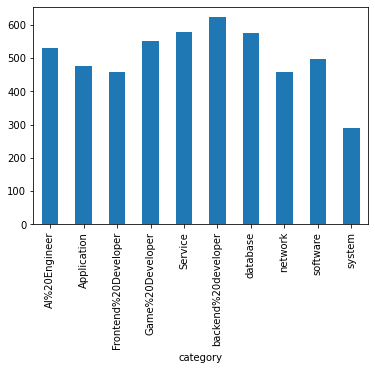

In [3]:
df.groupby(['category']).size().plot.bar()

## Preprocessing Data

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [5]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


## Dataset Class

In [6]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {j:i for i, j in enumerate(df.category.unique())}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [7]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

4036 504 505


## Model Building

In [8]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 10)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

## Training Loop

In [9]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████| 890/890 [02:04<00:00,  7.15it/s]


Epochs: 1 | Train Loss:  0.756                 | Train Accuracy:  0.342                 | Val Loss:  0.646                 | Val Accuracy:  0.527


100%|█████████████████████████████████████████| 890/890 [02:04<00:00,  7.12it/s]


Epochs: 2 | Train Loss:  0.444                 | Train Accuracy:  0.756                 | Val Loss:  0.298                 | Val Accuracy:  0.842


100%|█████████████████████████████████████████| 890/890 [02:04<00:00,  7.13it/s]


Epochs: 3 | Train Loss:  0.213                 | Train Accuracy:  0.936                 | Val Loss:  0.138                 | Val Accuracy:  0.977


100%|█████████████████████████████████████████| 890/890 [02:04<00:00,  7.15it/s]


Epochs: 4 | Train Loss:  0.106                 | Train Accuracy:  0.980                 | Val Loss:  0.071                 | Val Accuracy:  0.991


100%|█████████████████████████████████████████| 890/890 [02:04<00:00,  7.16it/s]


Epochs: 5 | Train Loss:  0.060                 | Train Accuracy:  0.990                 | Val Loss:  0.052                 | Val Accuracy:  0.991


## Evaluate Model on Test Data

In [49]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            m = nn.Softmax(dim=1)
            print("output:", m(output).cpu().numpy())
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test2)

output: [[0.0164133  0.0248567  0.0164133  0.9259034  0.0164133 ]
 [0.90263796 0.01532032 0.01535368 0.05136782 0.01532032]]
Test Accuracy:  1.000


In [30]:
df_test

,category,text
1154,politics,chancellor rallies labour voters gordon brown ...
207,politics,blair to face trust issue head on tony blair s...
2219,business,beijingers fume over parking fees choking traf...
1682,politics,blair rejects iraq advice calls tony blair has...
1122,business,turkey knocks six zeros off lira turkey is to ...
...,...,...
1638,sport,a november to remember last saturday one news...
1095,sport,african double in edinburgh world 5000m champi...
1130,tech,what price for trusted pc security you can ...
1294,sport,o driscoll/gregan lead aid stars ireland s bri...


In [40]:
arr = [["tech","tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-definition tv sets  which are big business in japan and the us  but slower to take off in europe because of the lack of high-definition programming. not only can people forward wind through adverts  they can also forget about abiding by network and channel schedules  putting together their own a-la-carte entertainment. but some us networks and cable and satellite companies are worried about what it means for them in terms of advertising revenues as well as  brand identity  and viewer loyalty to channels. although the us leads in this technology at the moment  it is also a concern that is being raised in europe  particularly with the growing uptake of services like sky+.  what happens here today  we will see in nine months to a years  time in the uk   adam hume  the bbc broadcast s futurologist told the bbc news website. for the likes of the bbc  there are no issues of lost advertising revenue yet. it is a more pressing issue at the moment for commercial uk broadcasters  but brand loyalty is important for everyone.  we will be talking more about content brands rather than network brands   said tim hanlon  from brand communications firm starcom mediavest.  the reality is that with broadband connections  anybody can be the producer of content.  he added:  the challenge now is that it is hard to promote a programme with so much choice.   what this means  said stacey jolna  senior vice president of tv guide tv group  is that the way people find the content they want to watch has to be simplified for tv viewers. it means that networks  in us terms  or channels could take a leaf out of google s book and be the search engine of the future  instead of the scheduler to help people find what they want to watch. this kind of channel model might work for the younger ipod generation which is used to taking control of their gadgets and what they play on them. but it might not suit everyone  the panel recognised. older generations are more comfortable with familiar schedules and channel brands because they know what they are getting. they perhaps do not want so much of the choice put into their hands  mr hanlon suggested.  on the other end  you have the kids just out of diapers who are pushing buttons already - everything is possible and available to them   said mr hanlon.  ultimately  the consumer will tell the market they want.   of the 50 000 new gadgets and technologies being showcased at ces  many of them are about enhancing the tv-watching experience. high-definition tv sets are everywhere and many new models of lcd (liquid crystal display) tvs have been launched with dvr capability built into them  instead of being external boxes. one such example launched at the show is humax s 26-inch lcd tv with an 80-hour tivo dvr and dvd recorder. one of the us s biggest satellite tv companies  directtv  has even launched its own branded dvr at the show with 100-hours of recording capability  instant replay  and a search function. the set can pause and rewind tv for up to 90 hours. and microsoft chief bill gates announced in his pre-show keynote speech a partnership with tivo  called tivotogo  which means people can play recorded programmes on windows pcs and mobile devices. all these reflect the increasing trend of freeing up multimedia so that people can watch what they want  when they want."],
       ["business","worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an $11bn (£5.8bn) fraud  never made accounting decisions  a witness has told jurors.  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.  on monday  defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision  .  not that i am aware of   mr myers replied.  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed.  no   replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief financial officer scott sullivan. defence lawyers have been trying to paint mr sullivan  who has admitted fraud and will testify later in the trial  as the mastermind behind worldcom s accounting house of cards.  mr ebbers  team  meanwhile  are looking to portray him as an affable boss  who by his own admission is more pe graduate than economist. whatever his abilities  mr ebbers transformed worldcom from a relative unknown into a $160bn telecoms giant and investor darling of the late 1990s. worldcom s problems mounted  however  as competition increased and the telecoms boom petered out. when the firm finally collapsed  shareholders lost about $180bn and 20 000 workers lost their jobs. mr ebbers  trial is expected to last two months and if found guilty the former ceo faces a substantial jail sentence. he has firmly declared his innocence."]]
df_test2 = pd.DataFrame(arr, columns=['category', 'text'])
df_test2

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


In [1]:
import numpy as np

arr = []
for _ in range(1000):
    arr2 = []
    for i in range(10):
        arr3 = np.random.randint(2**i, 2**(i+1))
        arr2.append(arr3)
    arr2 = np.random.permutation(arr2)
    arr.append(arr2 / np.linalg.norm(arr2))

In [2]:
arr[0]

array([0.12905418, 0.26906579, 0.00121749, 0.02556734, 0.00486997,
       0.01217492, 0.80963235, 0.05478715, 0.50160681, 0.00243498])

In [7]:
import torch
from torch import nn

m = nn.Softmax(dim=1)

In [13]:
sum(m(torch.Tensor(arr))[0])

tensor(1.0000)